In [81]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer(ngram_range=(1, 3))
v.fit(["Thor is looking for a job."])
v.vocabulary_

{'thor': 9,
 'is': 2,
 'looking': 6,
 'for': 0,
 'job': 5,
 'thor is': 10,
 'is looking': 3,
 'looking for': 7,
 'for job': 1,
 'thor is looking': 11,
 'is looking for': 4,
 'looking for job': 8}

In [82]:
corpus = [
    "Thor ate pizza",
    "Othmane is tall",
    "Othmane is eating pizza"
]

In [83]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)

    filtered_tokens = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

In [84]:
corpus_processed = [preprocess(text) for text in corpus]
corpus_processed

['thor eat pizza', 'Othmane tall', 'Othmane eat pizza']

In [85]:
v = CountVectorizer(ngram_range=(1, 2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'othmane': 2,
 'tall': 6,
 'othmane tall': 4,
 'othmane eat': 3}

In [86]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]], dtype=int64)

In [87]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [88]:
import pandas as pd

df = pd.read_json('news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [89]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [90]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class

df_business = df[df.category == "BUSINESS"].sample(min_samples, random_state=1022)
df_sports = df[df.category == "SPORTS"].sample(min_samples, random_state=1022)
df_crime = df[df.category == "CRIME"].sample(min_samples, random_state=1022)
df_science = df[df.category == "SCIENCE"].sample(min_samples, random_state=1022)

In [91]:
df_balanced = pd.concat([df_business, df_sports, df_crime, df_science], axis=0)
df_balanced.category.value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

In [92]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [161]:
df_balanced.head()

,text,category,category_num,preprocessed_text
4013,Four Telltale Signs You a Control Freak and Ho...,BUSINESS,0,Telltale sign Control Freak John Doe Control F...
1380,Tootsie Roll CEO Dies At 95,BUSINESS,0,Tootsie Roll CEO die 95
7873,"Women in Business: Q&A With Renae Scott, Chief...",BUSINESS,0,woman business Q&A Renae Scott Chief Marketing...
2093,In the Trenches on Black Friday Only Sunday es...,BUSINESS,0,Trenches Black Friday Sunday escape retail han...
3213,Martin Shkreli Found Guilty On Several Counts ...,BUSINESS,0,Martin Shkreli find Guilty count Fraud trial c...


In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=1022,
    stratify=df_balanced.category_num #same number of each category : 20% from each category
)

In [95]:
print(X_train.shape)
X_train.head()

(4419,)


7416    Pele Hospitalized For Back Surgery The legenda...
3213    Martin Shkreli Found Guilty On Several Counts ...
2368    LISTEN: How Our Obsession With Killing Bacteri...
4334    Wal-Mart To Challenge Amazon On Drone Delivery...
4235    ISIS Claims Minnesota Mall Attack Was Carried ...
Name: text, dtype: object

In [96]:
y_test.value_counts() #to verify stratify

category_num
0    277
2    276
1    276
3    276
Name: count, dtype: int64

In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter , just 1 here
     ('Multi NB', MultinomialNB())         
])

#fit with X_train and y_train
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       277
           1       0.93      0.87      0.90       276
           2       0.88      0.90      0.89       276
           3       0.93      0.85      0.89       276

    accuracy                           0.88      1105
   macro avg       0.89      0.88      0.88      1105
weighted avg       0.89      0.88      0.88      1105



In [98]:
X_test[:5]

3787    Second Victim Dies After Shooting At Florida G...
3741    From Test to Taste: The Journey Of A Coffee Be...
1860    Zach LaVine Dunk At All-Star Contest Is Unbeli...
6825    College Student Killed While Playing 'Pokemon ...
2830    Adorable Cotton Candy Girl Is The Hero We All ...
Name: text, dtype: object

In [99]:
y_test[:5]

3787    2
3741    0
1860    1
6825    2
2830    1
Name: category_num, dtype: int64

In [100]:
y_pred[:5] #to compare it with real result

array([2, 0, 1, 2, 1], dtype=int64)

In [101]:
clf = Pipeline([
     ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter , 1 & 2 here
     ('Multi NB', MultinomialNB())         
])

#fit with X_train and y_train
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       277
           1       0.94      0.80      0.86       276
           2       0.89      0.88      0.89       276
           3       0.93      0.82      0.87       276

    accuracy                           0.86      1105
   macro avg       0.87      0.86      0.86      1105
weighted avg       0.87      0.86      0.86      1105



In [102]:
clf = Pipeline([
     ('vectorizer_1_3_gram', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter , 1 to 3 here
     ('Multi NB', MultinomialNB())         
])

#fit with X_train and y_train
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       277
           1       0.95      0.79      0.86       276
           2       0.89      0.89      0.89       276
           3       0.92      0.80      0.85       276

    accuracy                           0.85      1105
   macro avg       0.87      0.85      0.85      1105
weighted avg       0.87      0.85      0.85      1105



In [137]:
#we wanted to train the model without any preprocessing first and check the performance.
#Now we will re-do same thing but with preprocessing of text
df_balanced['preprocessed_text'] = df_balanced['text'].apply(preprocess)

In [138]:
df_balanced.head()

,text,category,category_num,preprocessed_text
4013,Four Telltale Signs You a Control Freak and Ho...,BUSINESS,0,Telltale sign Control Freak John Doe Control F...
1380,Tootsie Roll CEO Dies At 95,BUSINESS,0,Tootsie Roll CEO die 95
7873,"Women in Business: Q&A With Renae Scott, Chief...",BUSINESS,0,woman business Q&A Renae Scott Chief Marketing...
2093,In the Trenches on Black Friday Only Sunday es...,BUSINESS,0,Trenches Black Friday Sunday escape retail han...
3213,Martin Shkreli Found Guilty On Several Counts ...,BUSINESS,0,Martin Shkreli find Guilty count Fraud trial c...


In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=1022,
    stratify=df_balanced.category_num #same number of each category : 20% from each category
)

In [145]:
print(X_train.shape)
X_train.head()

(4419,)


7416    Pele hospitalize Surgery legendary soccer play...
3213    Martin Shkreli find Guilty count Fraud trial c...
2368      LISTEN Obsession Killing Bacteria actually kill
4334    Wal Mart challenge Amazon Drone Delivery retai...
4235    ISIS Claims Minnesota Mall Attack carry Suppor...
Name: preprocessed_text, dtype: object

In [147]:
y_train.value_counts()

category_num
1    1105
3    1105
2    1105
0    1104
Name: count, dtype: int64

In [149]:
clf = Pipeline([
     ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter , 1 & 2 here
     ('Multi NB', MultinomialNB())         
])

#fit with X_train and y_train
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       277
           1       0.94      0.88      0.91       276
           2       0.86      0.93      0.90       276
           3       0.94      0.84      0.89       276

    accuracy                           0.89      1105
   macro avg       0.90      0.89      0.89      1105
weighted avg       0.90      0.89      0.89      1105



There is some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

In [151]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[254,   5,  11,   7],
       [ 10, 242,  19,   5],
       [ 12,   2, 258,   4],
       [ 24,   8,  11, 233]], dtype=int64)

Text(95.72222222222221, 0.5, 'REALITY')

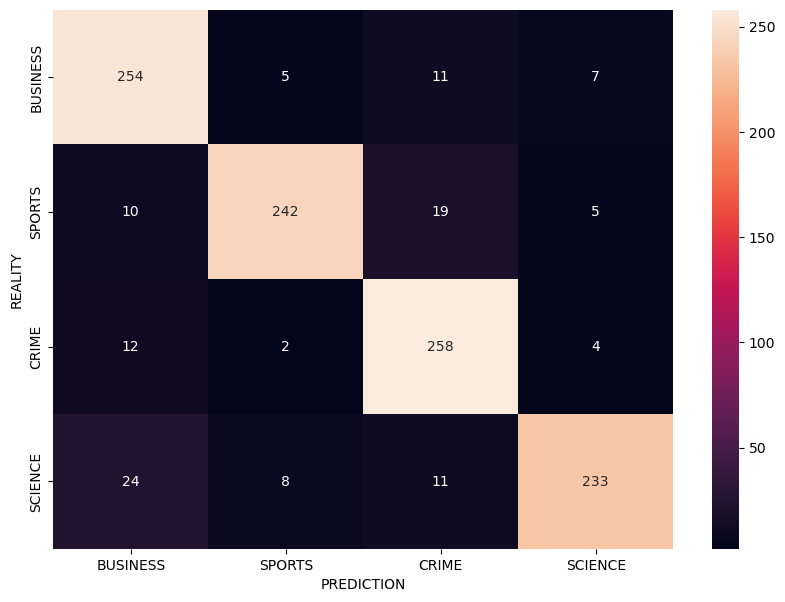

In [159]:
from matplotlib import pyplot as plt
import seaborn as sn

categories = ['BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE'] #to replace the numeric indices with their category names

plt.figure(figsize = (10,7))
sn.heatmap(cm, 
           annot=True, 
           fmt='d',
           xticklabels=categories, 
           yticklabels=categories
          )
plt.xlabel('PREDICTION')
plt.ylabel('REALITY')